In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

In [3]:
df_raw = pd.read_excel("AML and ATF Modelling Assignment data_std.xlsx", sheet_name = "data")
# data is too few and we may consider Synthetic tabular data methods

In [4]:
df_raw = df_raw.drop('tot_acct_num.1', axis = 1)

In [5]:
df_raw

,cust_tenure,cust_cdn_resident,prod_sav,prod_primary_sav_cnt,prod_cda,prod_primary_cda_cnt,prod_mor,prod_primary_mor_cnt,prod_llc,prod_primary_llc_cnt,...,max_acct_num,acct_type_num,tot_cross_border_val_12m,tot_cash_val_5m,tot_cross_border_cnt_12m,tot_cash_cnt_5m,avg_cash_5m,avg_wire_12m,cust_id_masked,rating
0,-1.024753,0.231869,-0.827535,-0.677491,-1.187365,-0.989953,-0.391077,-0.324689,1.840668,1.333540,...,-0.602150,-0.874462,-0.128725,-0.378492,-0.291457,-0.835541,-0.400281,-0.140963,004f8eab603ba30ea8fffd64ef39d5a990aff66b35f447...,0
1,-0.802710,-4.312772,1.208408,0.548246,0.842201,0.297862,-0.391077,-0.324689,-0.543281,-0.494249,...,-0.602150,-0.175843,-0.128725,0.027173,-0.291457,-0.576554,1.707971,-0.140963,00a38e35a8350be0d0d2ef2c7c40de54f049ff8359b54e...,1
2,-0.893597,0.231869,-0.827535,-0.677491,-1.187365,-0.989953,-0.391077,-0.324689,1.840668,1.333540,...,-0.602150,-0.874462,-0.128725,-0.378492,-0.291457,-0.835541,-0.400281,-0.140963,00d442a125b121bcd9e17ae58fdce2e7ae3513375afb2a...,0
3,-0.742306,0.231869,1.208408,0.548246,-1.187365,-0.989953,-0.391077,-0.324689,-0.543281,-0.494249,...,-0.602150,-0.874462,-0.128725,-0.378492,-0.291457,-0.835541,-0.400281,-0.140963,0114b5ce76aa3c09c460620cc19f1a77087ede3c326021...,0
4,0.574287,0.231869,-0.827535,-0.677491,0.842201,0.297862,-0.391077,-0.324689,-0.543281,-0.494249,...,-0.602150,-0.874462,-0.128725,-0.081122,-0.291457,0.718380,-0.142708,-0.140963,015a0ba1cb86c4e46bb01f8ed501254cfb7422e240583f...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,-0.724408,0.231869,1.208408,0.548246,-1.187365,-0.989953,-0.391077,-0.324689,-0.543281,-0.494249,...,-0.602150,-0.874462,-0.128725,-0.378492,-0.291457,-0.835541,-0.400281,-0.140963,fdf2f46a74ea777d5e0ef2b92319995df80c3c8a4b4432...,0
584,-0.748179,0.231869,1.208408,0.548246,0.842201,1.585677,-0.391077,-0.324689,-0.543281,-0.494249,...,0.057187,-0.175843,-0.107816,-0.378492,0.192658,-0.835541,-0.400281,-0.071333,fe345e6c8e0a7099429c7b16f086aab11e589b878d106a...,1
585,-0.239215,0.231869,1.208408,0.548246,0.842201,2.873492,-0.391077,-0.324689,-0.543281,-0.494249,...,1.375862,1.221395,0.227885,0.503676,3.097351,1.624834,0.082314,0.028687,ff6a3f3a489bacdc79cccd457e671575b11391cac9655b...,1
586,0.942306,0.231869,-0.827535,-0.677491,-1.187365,-0.989953,-0.391077,-0.324689,-0.543281,-0.494249,...,-1.261487,-1.573081,-0.128725,-0.366838,-0.291457,-0.447061,-0.359905,-0.140963,ff8fcb3b1b4bb844bff97217cef65259fe0523df71742e...,0


In [31]:
df_raw['cust_tenure'].rolling(10).mean().shift(-10).isna().sum()

10

In [32]:
df_raw['cust_tenure'].rolling(10).std()[9:] # std is unbiased

9      1.155061
10     1.126149
11     1.085562
12     1.010031
13     1.048836
         ...   
583    1.109371
584    1.105763
585    1.098287
586    0.846281
587    0.609096
Name: cust_tenure, Length: 579, dtype: float64

In [33]:
np.std(df_raw['cust_tenure'][1:11], ddof = 1) # np.std is biased by default

1.1261492680134026

In [24]:
from scipy.stats import rankdata

In [35]:
df_raw['cust_tenure'].rank()

0       12.5
1      171.5
2       81.0
3      197.0
4      430.0
       ...  
583    203.5
584    194.0
585    333.0
586    469.0
587    356.0
Name: cust_tenure, Length: 588, dtype: float64

In [36]:
rankdata(df_raw['cust_tenure'].rolling(10))

array([1.])

In [5]:
df_raw.isna().sum().sum() # no na values

0

In [24]:
len(df_raw["cust_id_masked"].unique()) # no duplicate customers

588

In [47]:
df_raw["rating"].value_counts() # 0 and 1 with ratio 2:1, no need for oversample, no need for reimbalance

0    390
1    198
Name: rating, dtype: int64

In [17]:
df_no_id = df_raw.drop("cust_id_masked", axis = 1)

In [23]:
# For now consider no outliers removing since tree model is quite robust to outliers
# min_rows = 10000
# index = -1
# # filter the outlier within 3 std dev range of the mean
# for col in range(len(df_no_id.columns)):
#     rows = len(df_no_id[(np.abs(stats.zscore(df_no_id.iloc[:,col])) <= 3)])
#     if rows < min_rows:
#         min_rows = rows
#         index = col

# df_filtered = df_no_id[(np.abs(stats.zscore(df_no_id.iloc[:,1])) <= 3)]
# # remove outlier based on the column with the most outliers
# data_train = df_filtered.drop("rating", axis=1)
# label_train = df_filtered["rating"]

In [18]:
data_train = df_no_id.drop("rating", axis=1)
label_train = df_no_id["rating"]

In [19]:
num_transformer = Pipeline(steps=[ 
    ('scaler', MinMaxScaler())
])

estimator = xgb.XGBClassifier()

pipeline = Pipeline(
    steps=[('preprocess', num_transformer), ('estimator', estimator)]
)

params = {
    'estimator__max_depth': [5, 6, 7],
    'estimator__gamma': [1, 5, 9],
    'estimator__colsample_bytree': [0.5, 0.7, 1],
    'estimator__min_child_weight': [1, 5, 10]
}

tuning_pipe = RandomizedSearchCV(pipeline, params, scoring='accuracy', cv=5, verbose=1)

In [20]:
tuning_pipe.fit(data_train, label_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[18:18:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:18:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:18:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:18:45

[18:18:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:18:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:18:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:18:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              Pipeline(steps=[('scaler',
                                                               MinMaxScaler())])),
                                             ('estimator',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
                                                            interactio

In [21]:
tuning_pipe.best_score_

0.7993191366072722

In [22]:
feature_importance_index = np.argsort(tuning_pipe.best_estimator_[1].feature_importances_)[::-1]
feature_importance_values = np.sort(tuning_pipe.best_estimator_[1].feature_importances_)[::-1]

In [23]:
feature_importance_values

array([0.2813378 , 0.09423999, 0.06442047, 0.06119716, 0.06096362,
       0.05544405, 0.05513538, 0.05043028, 0.04977078, 0.0482401 ,
       0.04129982, 0.03948875, 0.03237678, 0.02737898, 0.02244182,
       0.01583422, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [24]:
highest_features_cols = data_train.columns[feature_importance_index][:35]
highest_features_cols

Index(['avg_wire_12m', 'tot_cross_border_val_12m', 'avg_cash_5m',
       'txn_cash_in_avg_5m', 'txn_cash_out_val_5m', 'tot_cross_border_cnt_12m',
       'txn_large_in_cash_val_10k_5m', 'txn_cash_out_cnt_3m',
       'geo_mail_addr_country_rate_low', 'prod_asset_balance',
       'in_person_visit_cnt', 'txn_cash_out_avg_5m', 'prod_cda',
       'prod_primary_cda_cnt', 'prod_prim_acct_cnt', 'tot_cash_cnt_5m',
       'txn_wires_out_val_12m', 'txn_wires_out_high_val_12m',
       'txn_wires_in_high_val_12m', 'txn_cross_border_out_val_12m',
       'txn_cross_border_in_val_12m', 'prod_llc', 'txn_wires_in_med_val_12m',
       'txn_large_out_cash_val_9k_3m', 'txn_large_in_cash_val_9k_3m',
       'txn_large_out_cash_val_10k_3m', 'txn_large_in_cash_val_10k_3m',
       'txn_cash_out_avg_3m', 'txn_wires_in_val_12m',
       'txn_wires_in_low_val_12m', 'txn_wires_out_med_val_12m',
       'cust_cdn_resident', 'txn_wires_out_low_val_12m',
       'txn_wires_in_cnt_12m', 'txn_wires_out_cnt_12m'],
      dtyp

<AxesSubplot:>

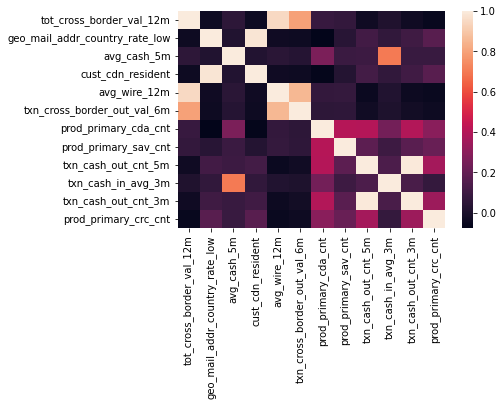

In [18]:
# tot_cross_border_val_12m, avg_wire_12m highly corrlated
# avg_cash_5m: txn_cash_out_val_5m, txn_cash_out_cnt_5m, txn_large_in_cash_val_9k_5m, txn_cash_in_avg_3m, txn_cash_in_avg_5m
# cust_cdn_resident, geo_mail_addr_country_rate_low are perfectly correlated, guess: basic all in Canada, and Canada is low risk
# country
"""
among the first 20 features ordered by importance, we delete avg_wire_12m, avg_cash_5m, txn_cash_in_avg_3m, 
txn_large_in_cash_val_9k_5m for high correlation with other features' issue
"""

In [33]:
selected_features = ['tot_cross_border_val_12m', 'txn_cash_out_cnt_5m', 'geo_mail_addr_country_rate_low',
                     'in_person_visit_cnt', 'prod_primary_cda_cnt', 'prod_primary_sav_cnt', 'prod_primary_crc_cnt',
                     'cust_tenure', 'prod_total_balance', 'prod_none_prim_acct_cnt', 'prod_primary_ted_cnt', 'prod_mor']

In [34]:
df_selected = df_no_id[selected_features]

In [35]:
df_selected

,tot_cross_border_val_12m,txn_cash_out_cnt_5m,geo_mail_addr_country_rate_low,in_person_visit_cnt,prod_primary_cda_cnt,prod_primary_sav_cnt,prod_primary_crc_cnt,cust_tenure,prod_total_balance,prod_none_prim_acct_cnt,prod_primary_ted_cnt,prod_mor
0,-0.128725,-0.739018,0.227768,-0.510405,-0.989953,-0.677491,-0.811988,-1.024753,-0.076465,-0.416987,-0.521852,-0.391077
1,-0.128725,-0.337964,-4.390428,0.064534,0.297862,0.548246,-0.811988,-0.802710,-0.391813,-0.416987,-0.521852,-0.391077
2,-0.128725,-0.739018,0.227768,-0.510405,-0.989953,-0.677491,-0.811988,-0.893597,-0.230200,-0.416987,-0.521852,-0.391077
3,-0.128725,-0.739018,0.227768,-0.510405,-0.989953,0.548246,-0.811988,-0.742306,-0.304636,-0.416987,-0.521852,-0.391077
4,-0.128725,1.065728,0.227768,0.187735,0.297862,-0.677491,-0.811988,0.574287,-0.304655,-0.416987,-0.521852,-0.391077
...,...,...,...,...,...,...,...,...,...,...,...,...
583,-0.128725,-0.739018,0.227768,-0.510405,-0.989953,0.548246,-0.811988,-0.724408,-0.304628,-0.416987,-0.521852,-0.391077
584,-0.107816,-0.739018,0.227768,1.994687,1.585677,0.548246,-0.811988,-0.748179,-0.304628,-0.416987,-0.521852,-0.391077
585,0.227885,1.667309,0.227768,1.296546,2.873492,0.548246,1.511365,-0.239215,-0.218259,-0.416987,0.662893,-0.391077
586,-0.128725,-0.337964,0.227768,-0.469338,-0.989953,-0.677491,-0.811988,0.942306,-0.059078,1.912595,-0.521852,-0.391077


<AxesSubplot:>

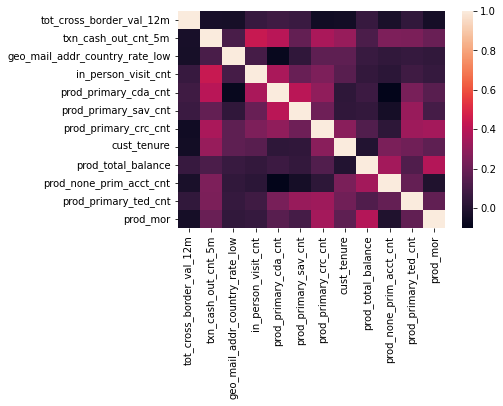

In [36]:
sns.heatmap(df_selected.corr())

In [37]:
X = df_selected
y = df_no_id['rating']

In [27]:
for feature in selected_features:
    print(f"The correlaton of {feature} vs the rating is: {df_no_id[[feature, 'rating']].corr().iloc[0, 1]}")

The correlaton of tot_cross_border_val_12m vs the rating is: 0.1035169369578487
The correlaton of txn_cash_out_cnt_5m vs the rating is: -0.01710534013102376
The correlaton of geo_mail_addr_country_rate_low vs the rating is: -0.219948712911795
The correlaton of in_person_visit_cnt vs the rating is: 0.1781014522236132
The correlaton of prod_primary_cda_cnt vs the rating is: 0.3141898197374996
The correlaton of prod_primary_sav_cnt vs the rating is: 0.13039316693130681
The correlaton of prod_primary_crc_cnt vs the rating is: 0.017148269469138704
The correlaton of cust_tenure vs the rating is: -0.1387922518523896
The correlaton of prod_total_balance vs the rating is: 0.07981126175468999
The correlaton of prod_none_prim_acct_cnt vs the rating is: -0.04980770371788715
The correlaton of prod_primary_ted_cnt vs the rating is: -0.04781141109305636
The correlaton of prod_mor vs the rating is: 0.05023101373005839


In [38]:
df_no_id['geo_mail_addr_country_rate_low'].value_counts()

 0.227768    559
-4.390428     29
Name: geo_mail_addr_country_rate_low, dtype: int64

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [40]:
train_data = X_train
train_data['rating'] = y_train

In [41]:
from autogluon.tabular import TabularDataset, TabularPredictor
label = 'rating'
predictor = TabularPredictor(label=label, eval_metric = 'accuracy').fit(train_data, presets = 'best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20221130_000736\"
Presets specified: ['best_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20221130_000736\"
AutoGluon Version:  0.4.2
Python Version:     3.9.7
Operating System:   Windows
Train Data Rows:    470
Train Data Columns: 12
Label Column: rating
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1556.87 MB
	Train Data (Original)  Memory Usage: 0.05 MB (0.0% of available memory

In [42]:
y_pred = predictor.predict(X_test)

In [43]:
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.8559322033898306
Evaluations on test data:
{
    "accuracy": 0.8559322033898306,
    "balanced_accuracy": 0.7937675070028012,
    "mcc": 0.6334469898343182,
    "f1": 0.7213114754098361,
    "precision": 0.8148148148148148,
    "recall": 0.6470588235294118
}
